In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [3]:
# checkpoint -> result 불러오기
import argparse
import torch
import torch.nn as nn
from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
from exp.exp_imputation import Exp_Imputation
from exp.exp_short_term_forecasting import Exp_Short_Term_Forecast
from exp.exp_long_term_forecasting_partial import Exp_Long_Term_Forecast_Partial
from exp.exp_anomaly_detection import Exp_Anomaly_Detection
from exp.exp_classification import Exp_Classification
from utils.print_args import print_args
import random
import time

In [4]:
# fix random seed
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
parser = argparse.ArgumentParser(description='TimesNet')

In [5]:
# config 지정 -> 오류 방지를 위해 

# basic config
parser.add_argument('--task_name', type=str, default='long_term_forecast',
                    help='task name, options:[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]')
parser.add_argument('--is_training', type=int, default=1, help='status')
parser.add_argument('--model_id', type=str, default='test', help='model id')
parser.add_argument('--model', type=str, default='Autoformer',
                    help='model name, options: [Autoformer, Transformer, TimesNet]')

# data loader
parser.add_argument('--data', type=str, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# added option 
parser.add_argument('--train_ratio', type=float, default=0.7, help='train data ratio')
parser.add_argument('--test_ratio', type=float, default=0.2, help='test data ratio')
parser.add_argument('--train_step', type=float, default=1.0, help='train data with certain stes. for example train_step=2 means only train even number of data')

# SparseTSF
parser.add_argument('--period_len', type=int, default=24, help='period length')

# PITS
parser.add_argument('--fc_dropout', type=float, default=0.05, help='fully connected dropout')
parser.add_argument('--head_dropout', type=float, default=0.0, help='head dropout')
parser.add_argument('--patch_len', type=int, default=16, help='patch length')
parser.add_argument('--stride', type=int, default=8, help='stride')
parser.add_argument('--shared_embedding', type=int, default=1, help='stride')
parser.add_argument('--padding_patch', default='end', help='None: None; end: padding on the end')
parser.add_argument('--revin', type=int, default=1, help='RevIN; True 1 False 0')
parser.add_argument('--affine', type=int, default=0, help='RevIN-affine; True 1 False 0')
parser.add_argument('--subtract_last', type=int, default=0, help='0: subtract mean; 1: subtract last')
parser.add_argument('--decomposition', type=int, default=0, help='decomposition; True 1 False 0')
parser.add_argument('--kernel_size', type=int, default=25, help='decomposition-kernel')
parser.add_argument('--individual', type=int, default=0, help='individual head; True 1 False 0')

# Piformer
parser.add_argument('--joint_var', type=int, default=0, help='use attention for each patching; True 1 False 0')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')
parser.add_argument('--seasonal_patterns', type=str, default='Monthly', help='subset for M4')
parser.add_argument('--inverse', action='store_true', help='inverse output data', default=False)

# inputation task
parser.add_argument('--mask_rate', type=float, default=0.25, help='mask ratio')

# anomaly detection task
parser.add_argument('--anomaly_ratio', type=float, default=0.25, help='prior anomaly ratio (%)')

# model define
parser.add_argument('--expand', type=int, default=2, help='expansion factor for Mamba')
parser.add_argument('--d_conv', type=int, default=4, help='conv kernel size for Mamba')
parser.add_argument('--top_k', type=int, default=5, help='for TimesBlock')
parser.add_argument('--num_kernels', type=int, default=6, help='for Inception')
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--channel_independence', type=int, default=1,
                    help='0: channel dependence 1: channel independence for FreTS model')
parser.add_argument('--decomp_method', type=str, default='moving_avg',
                    help='method of series decompsition, only support moving_avg or dft_decomp')
parser.add_argument('--use_norm', type=int, default=1, help='whether to use normalize; True 1 False 0')
parser.add_argument('--down_sampling_layers', type=int, default=0, help='num of down sampling layers')
parser.add_argument('--down_sampling_window', type=int, default=1, help='down sampling window size')
parser.add_argument('--down_sampling_method', type=str, default=None,
                    help='down sampling method, only support avg, max, conv')
parser.add_argument('--seg_len', type=int, default=48,
                    help='the length of segmen-wise iteration of SegRNN')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--itr', type=int, default=1, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='MSE', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# de-stationary projector params
parser.add_argument('--p_hidden_dims', type=int, nargs='+', default=[128, 128],
                    help='hidden layer dimensions of projector (List)')
parser.add_argument('--p_hidden_layers', type=int, default=2, help='number of hidden layers in projector')

# metrics (dtw)
parser.add_argument('--use_dtw', type=bool, default=False, 
                    help='the controller of using dtw metric (dtw is time consuming, not suggested unless necessary)')

# Augmentation
parser.add_argument('--augmentation_ratio', type=int, default=0, help="How many times to augment")
parser.add_argument('--seed', type=int, default=2, help="Randomization seed")
parser.add_argument('--jitter', default=False, action="store_true", help="Jitter preset augmentation")
parser.add_argument('--scaling', default=False, action="store_true", help="Scaling preset augmentation")
parser.add_argument('--permutation', default=False, action="store_true", help="Equal Length Permutation preset augmentation")
parser.add_argument('--randompermutation', default=False, action="store_true", help="Random Length Permutation preset augmentation")
parser.add_argument('--magwarp', default=False, action="store_true", help="Magnitude warp preset augmentation")
parser.add_argument('--timewarp', default=False, action="store_true", help="Time warp preset augmentation")
parser.add_argument('--windowslice', default=False, action="store_true", help="Window slice preset augmentation")
parser.add_argument('--windowwarp', default=False, action="store_true", help="Window warp preset augmentation")
parser.add_argument('--rotation', default=False, action="store_true", help="Rotation preset augmentation")
parser.add_argument('--spawner', default=False, action="store_true", help="SPAWNER preset augmentation")
parser.add_argument('--dtwwarp', default=False, action="store_true", help="DTW warp preset augmentation")
parser.add_argument('--shapedtwwarp', default=False, action="store_true", help="Shape DTW warp preset augmentation")
parser.add_argument('--wdba', default=False, action="store_true", help="Weighted DBA preset augmentation")
parser.add_argument('--discdtw', default=False, action="store_true", help="Discrimitive DTW warp preset augmentation")
parser.add_argument('--discsdtw', default=False, action="store_true", help="Discrimitive shapeDTW warp preset augmentation")
parser.add_argument('--extra_tag', type=str, default="", help="Anything extra")

#piformer
parser.add_argument('--shuffle', type=int, default=1, help="Shuffle data when training")
parser.add_argument('--base_model', type=str, default="iTransformer", help="Base Model Type")

_StoreAction(option_strings=['--base_model'], dest='base_model', nargs=None, const=None, default='iTransformer', type=<class 'str'>, choices=None, help='Base Model Type', metavar=None)

In [6]:
# argument_text로 parser의 argument 지정 - 반드시 불러오는 모델과 동일하게 지정해야 함.

parse_seq = """  --task_name long_term_forecast \
  --is_training 1 \
  --root_path ./dataset/exchange_rate/ \
  --data_path exchange_rate.csv \
  --model_id DiTransformer_Exchange_96_96\
  --model DiTransformer_decomp \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 8 \
  --dec_in 8 \
  --c_out 8 \
  --batch_size 4 \
  --train_ratio 0.6 \
  --d_model 64 \
  --d_ff 128 \
  --des 'Exp' \
  --shuffle 0\
  --itr 1
"""
args = parser.parse_args(parse_seq.split())
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

print('Args in experiment:')
print(args)

Args in experiment:
Namespace(activation='gelu', affine=0, anomaly_ratio=0.25, augmentation_ratio=0, base_model='iTransformer', batch_size=4, c_out=8, channel_independence=1, checkpoints='./checkpoints/', d_conv=4, d_ff=128, d_layers=1, d_model=64, data='custom', data_path='exchange_rate.csv', dec_in=8, decomp_method='moving_avg', decomposition=0, des="'Exp'", devices='0,1,2,3', discdtw=False, discsdtw=False, distil=True, down_sampling_layers=0, down_sampling_method=None, down_sampling_window=1, dropout=0.1, dtwwarp=False, e_layers=2, embed='timeF', enc_in=8, expand=2, extra_tag='', factor=3, fc_dropout=0.05, features='M', freq='h', gpu=0, head_dropout=0.0, individual=0, inverse=False, is_training=1, itr=1, jitter=False, joint_var=0, kernel_size=25, label_len=48, learning_rate=0.0001, loss='MSE', lradj='type1', magwarp=False, mask_rate=0.25, model='DiTransformer_decomp', model_id='DiTransformer_Exchange_96_96', moving_avg=25, n_heads=8, num_kernels=6, num_workers=10, output_attention=F

In [7]:
# 모델 호출 - Exp_Long_Term_Forecast
exp_model = Exp_Long_Term_Forecast(args)
exp_model._build_model()

Use GPU: cuda:0


Model(
  (decomposition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (enc_embedding_s): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (linear_adjustment): LinearApproximation(
    (linear): Linear(in_features=1, out_features=8, bias=True)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=64, out_features=64, bias=True)
          (key_projection): Linear(in_features=64, out_features=64, bias=True)
          (valu

In [16]:
iTransformer_result = 'long_term_forecast_iTransformer_Exchange_96_96_Mod-iTransformer_data-exchange_rate.csv_(96to96)_0(1727246961)'

In [18]:
# 위의 argument와 맞는 모델 호출
checkpoint_path = './checkpoints/'
setting_path = iTransformer_result
model_path = f"{checkpoint_path}{setting_path}/checkpoint.pth"
exp_model.model.load_state_dict(torch.load(model_path), strict=False)

_IncompatibleKeys(missing_keys=['enc_embedding_s.value_embedding.weight', 'enc_embedding_s.value_embedding.bias', 'linear_adjustment.linear.weight', 'linear_adjustment.linear.bias', 'encoder_s.attn_layers.0.attention.query_projection.weight', 'encoder_s.attn_layers.0.attention.query_projection.bias', 'encoder_s.attn_layers.0.attention.key_projection.weight', 'encoder_s.attn_layers.0.attention.key_projection.bias', 'encoder_s.attn_layers.0.attention.value_projection.weight', 'encoder_s.attn_layers.0.attention.value_projection.bias', 'encoder_s.attn_layers.0.attention.out_projection.weight', 'encoder_s.attn_layers.0.attention.out_projection.bias', 'encoder_s.attn_layers.0.conv1.weight', 'encoder_s.attn_layers.0.conv1.bias', 'encoder_s.attn_layers.0.conv2.weight', 'encoder_s.attn_layers.0.conv2.bias', 'encoder_s.attn_layers.0.norm1.weight', 'encoder_s.attn_layers.0.norm1.bias', 'encoder_s.attn_layers.0.norm2.weight', 'encoder_s.attn_layers.0.norm2.bias', 'encoder_s.attn_layers.1.attention

In [19]:
%matplotlib inline

In [20]:
from utils.metrics import *
from utils.tools import linear_regression_direct, linear_predict
from data_provider.data_factory import data_provider
from data_provider.data_loader import Dataset_Custom

In [21]:
# data_provider -> Exchange_rate
dataset_exchange_96 = Dataset_Custom(args, './dataset/exchange_rate/',
                                    flag='train', size=(96, 48, 96),
                                    features='M', data_path = 'exchange_rate.csv',
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=0.6, test_ratio=0.2)
dataset_exchange_96_test = Dataset_Custom(args, './dataset/exchange_rate/',
                                    flag='test', size=(96, 48, 96),
                                    features='M', data_path = 'exchange_rate.csv',
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=0.6, test_ratio=0.2)

In [22]:
exp_model.model.eval()

Model(
  (decomposition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (enc_embedding_s): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (linear_adjustment): LinearApproximation(
    (linear): Linear(in_features=1, out_features=8, bias=True)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=64, out_features=64, bias=True)
          (key_projection): Linear(in_features=64, out_features=64, bias=True)
          (valu

In [23]:
# 모델 훈련셋 결과 확인하기
from data_provider.data_factory import data_provider
from torch.utils.data import DataLoader

dataset_exchange_96_loader = DataLoader(
            dataset_exchange_96,
            batch_size=1, # 모든 데이터셋을 확인해야 해서 batch_size를 강제로 1로 조정.
            shuffle=False,
            num_workers=args.num_workers,
            drop_last=False)

In [24]:
dataset_exchange_96_loader = DataLoader(
            dataset_exchange_96,
            batch_size=8, # 모든 데이터셋을 확인해야 해서 batch_size를 강제로 1로 조정.
            shuffle=False,
            num_workers=args.num_workers,
            drop_last=False)

In [25]:
dataset_exchange_96[0][0].shape, dataset_exchange_96[0][1].shape

((96, 8), (144, 8))

In [26]:
X = np.array([[t] for t in range(-args.seq_len, 0)])  # X는 입력 feature, shape: [seq_len, 1]
X_new = np.array([[t] for t in range(args.seq_len)])  # 예측을 위한 새로운 시간 변수

In [27]:
X.shape

(96, 1)

In [28]:
theta_best = linear_regression_direct(torch.Tensor(X), dataset_exchange_96[0][0][:,0], exp_model.device)

In [29]:
linear_predict(X_new, theta_best, exp_model.device)

tensor([0.5581, 0.5555, 0.5528, 0.5502, 0.5475, 0.5448, 0.5422, 0.5395, 0.5369,
        0.5342, 0.5315, 0.5289, 0.5262, 0.5236, 0.5209, 0.5183, 0.5156, 0.5129,
        0.5103, 0.5076, 0.5050, 0.5023, 0.4996, 0.4970, 0.4943, 0.4917, 0.4890,
        0.4863, 0.4837, 0.4810, 0.4784, 0.4757, 0.4730, 0.4704, 0.4677, 0.4651,
        0.4624, 0.4598, 0.4571, 0.4544, 0.4518, 0.4491, 0.4465, 0.4438, 0.4411,
        0.4385, 0.4358, 0.4332, 0.4305, 0.4278, 0.4252, 0.4225, 0.4199, 0.4172,
        0.4145, 0.4119, 0.4092, 0.4066, 0.4039, 0.4013, 0.3986, 0.3959, 0.3933,
        0.3906, 0.3880, 0.3853, 0.3826, 0.3800, 0.3773, 0.3747, 0.3720, 0.3693,
        0.3667, 0.3640, 0.3614, 0.3587, 0.3560, 0.3534, 0.3507, 0.3481, 0.3454,
        0.3427, 0.3401, 0.3374, 0.3348, 0.3321, 0.3295, 0.3268, 0.3241, 0.3215,
        0.3188, 0.3162, 0.3135, 0.3108, 0.3082, 0.3055], device='cuda:0',
       grad_fn=<SqueezeBackward1>)

In [30]:
linear_predict(X_new, theta_best, exp_model.device).shape

torch.Size([96])

In [31]:
resx = np.concatenate([X, X_new], axis=0).reshape(-1)

batch_x_torch = torch.Tensor(dataset_exchange_96[0][0]).unsqueeze(0).to(exp_model.device)

In [32]:
res1 = exp_model.model(batch_x_torch, None, batch_x_torch, None)[0].detach().cpu().numpy()
res1.squeeze()

array([[ 0.65440446,  0.23669653,  1.0085595 , -0.24355622,  2.7172422 ,
        -2.2284634 , -1.5419377 , -0.1942948 ],
       [ 0.60250556,  0.06126461,  0.97071296, -0.32928258,  2.7141528 ,
        -2.2603035 , -1.5539633 , -0.195911  ],
       [ 0.60391927,  0.13748074,  1.0210639 , -0.32013643,  2.714704  ,
        -2.3363943 , -1.5824238 , -0.19423862],
       [ 0.6497218 ,  0.12428883,  0.97896284, -0.31657127,  2.7159376 ,
        -2.2435982 , -1.5430311 , -0.17873189],
       [ 0.5594865 ,  0.10544328,  0.9667099 , -0.3233738 ,  2.7180967 ,
        -2.2959042 , -1.5514531 , -0.22924072],
       [ 0.5601493 ,  0.01426513,  0.9592182 , -0.38909218,  2.7151377 ,
        -2.2219605 , -1.5657623 , -0.2441897 ],
       [ 0.7231173 ,  0.15472753,  1.0480005 , -0.24589863,  2.7216306 ,
        -2.2243333 , -1.5262965 , -0.15472433],
       [ 0.6239877 ,  0.191789  ,  1.0108289 , -0.23234603,  2.7187483 ,
        -2.2569692 , -1.5307424 , -0.1949232 ],
       [ 0.6602876 ,  0.10973413

In [33]:
rt = res1.squeeze()
lix_lin_before = [linear_predict(X, linear_regression_direct(torch.Tensor(X), dataset_exchange_96[0][0][:,v], exp_model.device), exp_model.device) for v in range(8)]
lix_linear = [linear_predict(X_new, linear_regression_direct(torch.Tensor(X), dataset_exchange_96[0][0][:,v], exp_model.device), exp_model.device) for v in range(8)]

In [34]:
lix_lin_before_24 = [linear_predict(X, linear_regression_direct(torch.Tensor(X[-24:]), dataset_exchange_96[0][0][-24:,v], exp_model.device), exp_model.device) for v in range(8)]
lix_linear_24 = [linear_predict(X_new, linear_regression_direct(torch.Tensor(X[-24:]), dataset_exchange_96[0][0][-24:,v], exp_model.device), exp_model.device) for v in range(8)]

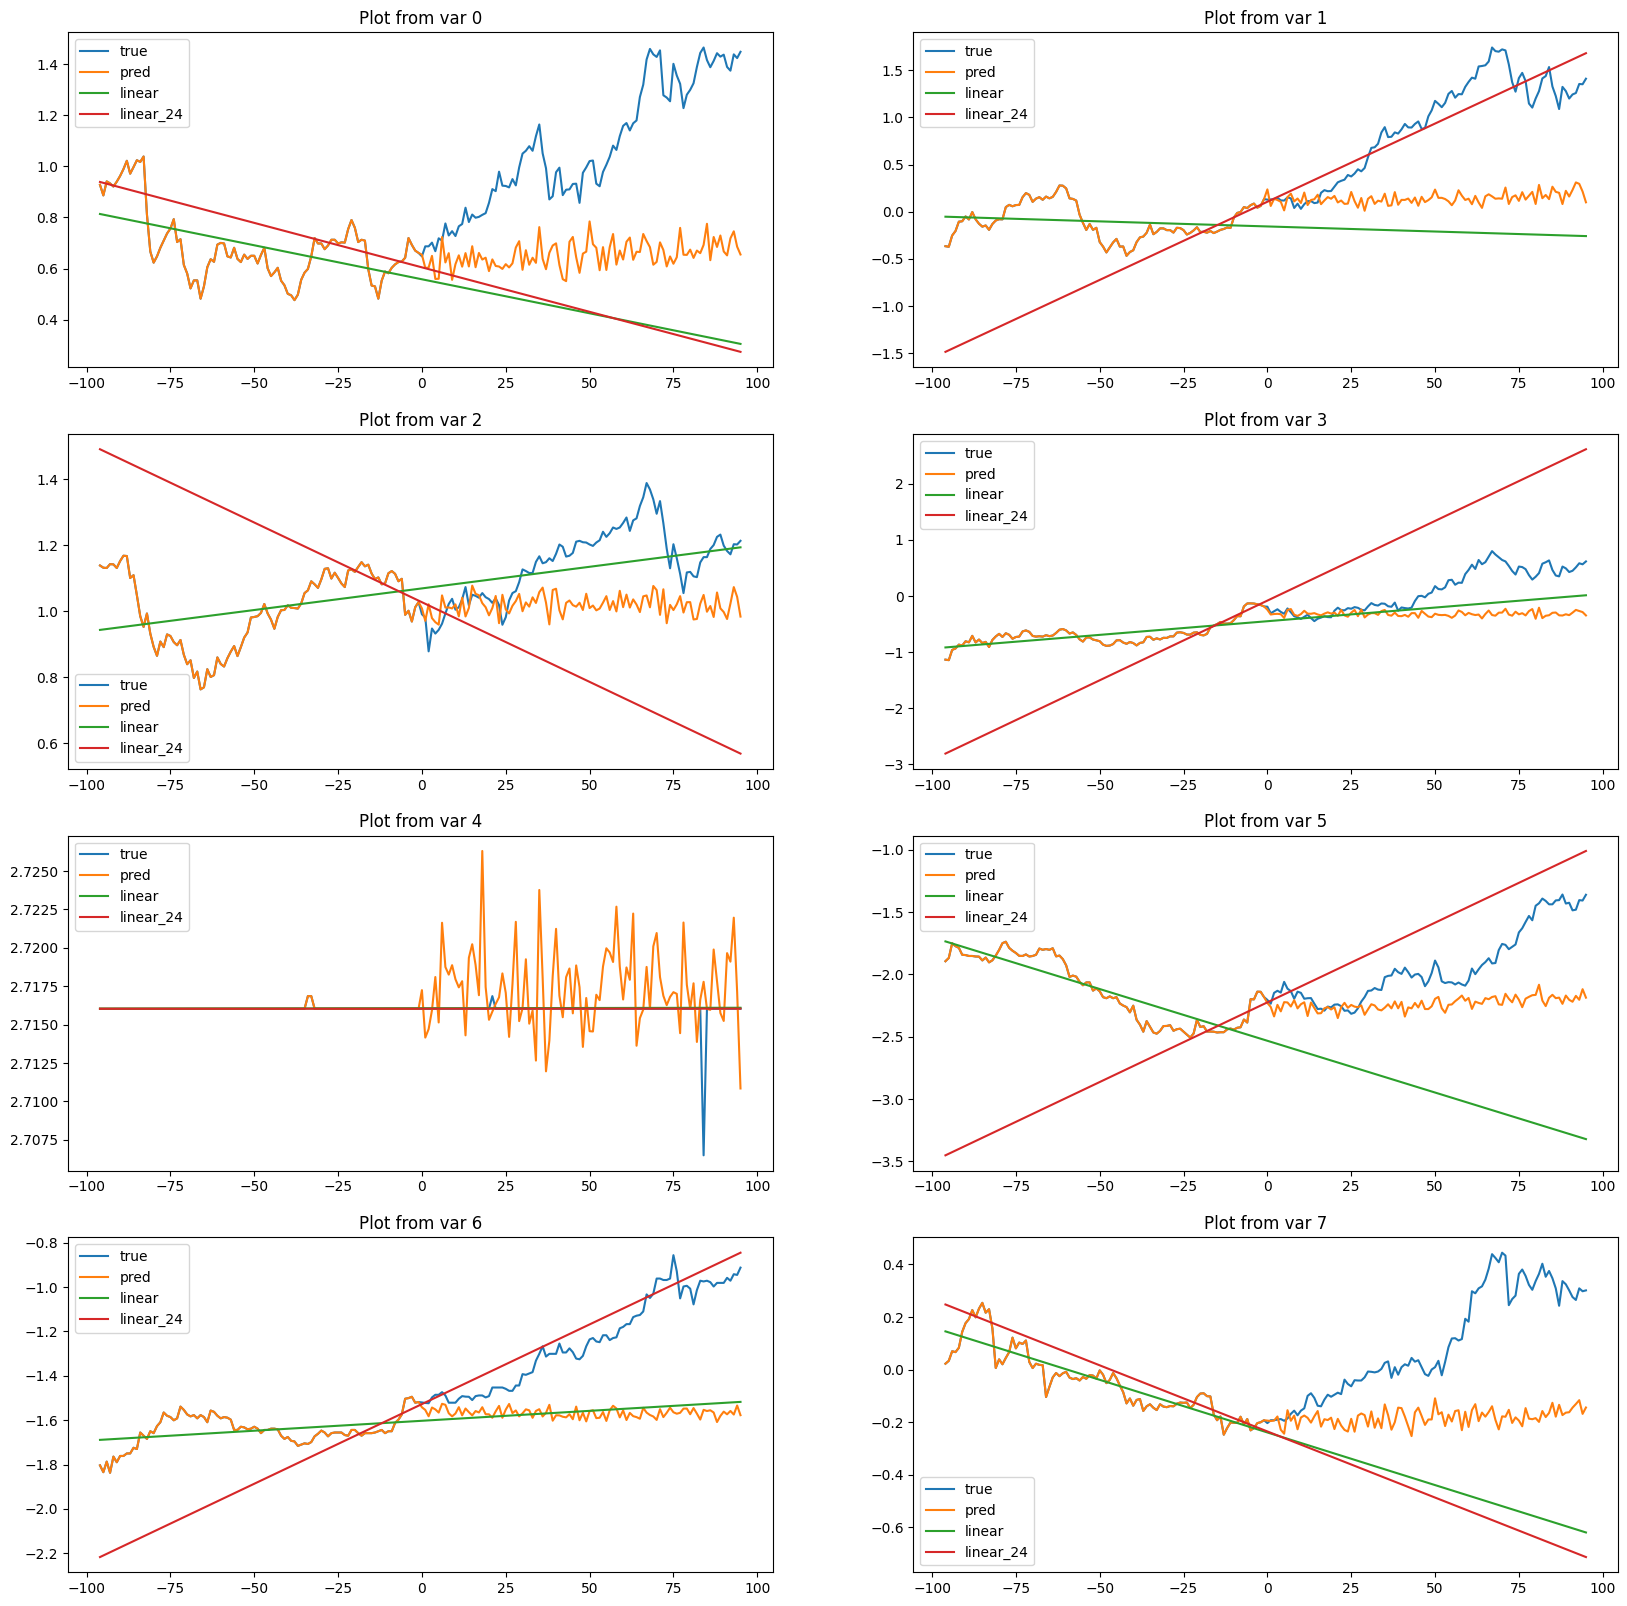

In [35]:
# 4*2 그래프 그리기
# iTransformer 예측, linear예측, 실제값 
idx = 0
fig, axs = plt.subplots(4, 2, figsize=(20, 20))  # 5행 10열 서브플롯, figure 크기 조정

for i in range(4):
    for j in range(2):
        val = i*2 + j
        y0 = dataset_exchange_96[idx][0][:, val] # 시작값
        y_true = dataset_exchange_96[idx][1][-96:, val] # 참값
        y_pred = rt[:, val]
        y_lin_before = lix_lin_before[val].detach().cpu().numpy()
        y_lin = lix_linear[val].detach().cpu().numpy()
        y_lin_before_24 = lix_lin_before_24[val].detach().cpu().numpy()
        y_lin_24 = lix_linear_24[val].detach().cpu().numpy()
        ax = axs[i, j]
        ax.plot(resx, np.concatenate([y0, y_true]), label='true')  # 예제: 서로 다른 사인 곡선 플롯
        ax.plot(resx, np.concatenate([y0, y_pred]), label='pred')
        ax.plot(resx, np.concatenate([y_lin_before, y_lin]), label='linear')
        ax.plot(resx, np.concatenate([y_lin_before_24, y_lin_24]), label='linear_24')
        ax.set_title(f'Plot from var {(i*2 + j)}')
        ax.legend()
        # ax.axis('off')  # 축을 끄고 싶다면 사용

plt.show()

In [36]:
# 우선 train_set의 data_exchange를 바탕으로 측정값 참값 가져기
# 트레인 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_te_tr = [] # 예측값
trues_te_tr = [] # 참값
preds_te_lin = [] # 96_lin
preds_te_lin_24 = [] # 24_lin

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
    batch_x = batch_x.float().to(exp_model.device)
    batch_y = batch_y.float().to(exp_model.device)

    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)

    batch_x_mark = batch_x_mark.float().to(exp_model.device)
    batch_y_mark = batch_y_mark.float().to(exp_model.device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp_model.device)
    # encoder - decoder

    # use_amp도 사용하지 않음, 
    outputs = exp_model.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
    
    # 각 배치와 변수에 대해 선형 회귀 해를 계산
    vals = [[linear_regression_direct(X, batch_x.permute(0,2,1)[idx, var , :], exp_model.device) for var in range(N)] for idx in range(B)]
    lin_result = [[linear_predict(X_new, vals[idx][var], exp_model.device) for var in range(N)] for idx in range(B)]
    # 결과를 3D 텐서로 변환
    lin_result = torch.stack([torch.stack(lin_result[idx], dim=0) for idx in range(B)], dim=0).to(exp_model.device)

    # 24 조각에 대해서도 계산
    vals_24 = [[linear_regression_direct(X[-24:], batch_x.permute(0,2,1)[idx, var , -24:], exp_model.device) for var in range(N)] for idx in range(B)]
    lin_result_24 = [[linear_predict(X_new, vals_24[idx][var], exp_model.device) for var in range(N)] for idx in range(B)]
    # 결과를 3D 텐서로 변환
    lin_result_24 = torch.stack([torch.stack(lin_result_24[idx], dim=0) for idx in range(B)], dim=0).to(exp_model.device)
    
    outputs = outputs[:, -args.pred_len:, :]
    batch_y = batch_y[:, -args.pred_len:, :].to(exp_model.device)
    outputs = outputs.detach().cpu().numpy()
    batch_y = batch_y.detach().cpu().numpy()

    pred = outputs
    true = batch_y

    preds_te_tr.append(pred)
    trues_te_tr.append(true)
    preds_te_lin.append(lin_result)
    preds_te_lin_24.append(lin_result_24)

    if (i+1)%100==0:
        print(f"step {i+1} completed")
    
preds_te_tr = np.concatenate(preds_te_tr, axis=0)
trues_te_tr = np.concatenate(trues_te_tr, axis=0)


step 100 completed
step 200 completed
step 300 completed
step 400 completed
step 500 completed


In [37]:
preds_te_lin = torch.concat(preds_te_lin, axis=0).detach().cpu().numpy()
preds_te_lin_24 = torch.concat(preds_te_lin_24, axis=0).detach().cpu().numpy()

In [38]:
preds_te_lin = np.transpose(preds_te_lin, (0,2,1))
preds_te_lin_24 = np.transpose(preds_te_lin_24, (0,2,1))

In [39]:
# 마지막으로 torch 모델을 제작 > 훈련
class CombinedModel(nn.Module):
    def __init__(self, res_A, res_B, res_C):
        super(CombinedModel, self).__init__()
        self.res_A = res_A  # iTransformer train_result
        self.res_B = res_B  # lin_reg_96 train_result
        self.res_C = res_C
        self.a = nn.Parameter(torch.ones(1, device=exp_model.device)*0.2, requires_grad=True)
        self.b = nn.Parameter(torch.zeros(1, device=exp_model.device), requires_grad=True)
        self.c = nn.Parameter(torch.zeros(1, device=exp_model.device), requires_grad=True)
        # self.d = nn.Parameter(torch.zeros(1, device=exp_model.device), requires_grad=True)
    
    def forward(self, x):
        output_A = self.res_A(x)
        output_B = self.res_B(x)
        output_C = self.res_C(x)
        combined_output = self.a * output_A + self.b * output_B + output_C * self.c # + self.d
        return combined_output

In [40]:
# model_output_function

def res_iTransformer(batch_x):
    
    return exp_model.model(batch_x, None, torch.zeros_like(batch_x), None)[0]

def res_lin_reg(batch_x):
    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)
    # 각 배치와 변수에 대해 선형 회귀 해를 계산
    vals = [[linear_regression_direct(X, batch_x.permute(0,2,1)[idx, var , :], exp_model.device) for var in range(N)] for idx in range(B)]
    lin_result = [[linear_predict(X_new, vals[idx][var], exp_model.device) for var in range(N)] for idx in range(B)]
    # 결과를 3D 텐서로 변환
    lin_result = torch.stack([torch.stack(lin_result[idx], dim=0) for idx in range(B)], dim=0).to(exp_model.device).permute(0,2,1)
    return lin_result

def res_lin_reg_24(batch_x):
    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)
    # 24 조각에 대해서도 계산
    vals_24 = [[linear_regression_direct(X[-24:], batch_x.permute(0,2,1)[idx, var , -24:], exp_model.device) for var in range(N)] for idx in range(B)]
    lin_result_24 = [[linear_predict(X_new, vals_24[idx][var], exp_model.device) for var in range(N)] for idx in range(B)]
    # 결과를 3D 텐서로 변환
    lin_result_24 = torch.stack([torch.stack(lin_result_24[idx], dim=0) for idx in range(B)], dim=0).to(exp_model.device).permute(0,2,1)
    return lin_result_24

In [41]:
combine_model_test = CombinedModel(res_iTransformer, res_lin_reg, res_lin_reg_24)

In [42]:
combined_outputs = []
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
    batch_x = batch_x.float().to(exp_model.device)
    batch_y = batch_y.float().to(exp_model.device)
    combined_output = combine_model_test(batch_x)
    combined_outputs.append(combined_output)
    if (i+1)%100==0:
        print(f"step {i+1} completed")

step 100 completed
step 200 completed
step 300 completed
step 400 completed
step 500 completed


In [43]:
combined_outputs[0].shape

torch.Size([8, 96, 8])

In [44]:
combine_model_test.a, combine_model_test.b, combine_model_test.c # train 되지 않은 상태

(Parameter containing:
 tensor([0.2000], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.], device='cuda:0', requires_grad=True))

In [45]:
num_epochs = 1
combine_model_test = CombinedModel(res_iTransformer, res_lin_reg, res_lin_reg_24)
# combine_model_test training
combine_model_test.train()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam([combine_model_test.a, combine_model_test.b, combine_model_test.c], lr=0.0005)


In [46]:
# 일부만 테스트
random_val = 0.5
train_len = len(dataset_exchange_96)
selected_indices = [int(i/random_val) for i in range(int(train_len*random_val)+1) ]

In [47]:
cnt = 0
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
    # if i in selected_indices:
        cnt += 1
        batch_x = batch_x.float().to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
        targets = batch_y[:, -args.pred_len:, :].to(exp_model.device)
        optimizer.zero_grad()
        outputs = combine_model_test(batch_x)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (cnt+1) % 100 == 0:
            print(f"epoch {cnt+1} done, loss {loss}") 

epoch 100 done, loss 0.28559255599975586
epoch 200 done, loss 0.2822307348251343
epoch 300 done, loss 0.34557589888572693
epoch 400 done, loss 0.07543648779392242
epoch 500 done, loss 0.3117835521697998


In [48]:
combine_model_test.eval()
combine_model_test.a, combine_model_test.b, combine_model_test.c # train 되지 않은 상태

(Parameter containing:
 tensor([0.3700], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1665], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1557], device='cuda:0', requires_grad=True))

In [49]:
MSE(preds_te_tr, trues_te_tr), MAE(preds_te_tr, trues_te_tr), SMAE(preds_te_tr, trues_te_tr)

(0.32300097, 0.39706883, 0.3094158)

In [50]:
# 실제 테스트 셋 불러와서 처리
a, b, c = combine_model_test.a[0].item(), combine_model_test.b[0].item(), combine_model_test.c[0].item()

In [51]:
MSE(a*preds_te_tr + b*preds_te_lin + c*preds_te_lin_24, trues_te_tr), MAE(a*preds_te_tr + b*preds_te_lin + c*preds_te_lin_24, trues_te_tr),  SMAE(a*preds_te_tr + b*preds_te_lin + c*preds_te_lin_24, trues_te_tr)

(0.2042625, 0.34584585, 0.10922297)

In [52]:
a1, b1, c1 = a/(a+b+c), b/(a+b+c), c/(a+b+c)

In [53]:
MSE(a1*preds_te_tr + b1*preds_te_lin + c1*preds_te_lin_24, trues_te_tr), MAE(a1*preds_te_tr + b1*preds_te_lin + c1*preds_te_lin_24, trues_te_tr),  SMAE(a1*preds_te_tr + b1*preds_te_lin + c1*preds_te_lin_24, trues_te_tr)

(0.17770687, 0.2853035, 0.16562265)

In [54]:
# 실제 데이터 셋 호출
result_list = ['pred.npy', 'true.npy']
result_path = './results/'
np_pred = np.load(f"{result_path}{iTransformer_result}/{result_list[0]}")
np_true = np.load(f"{result_path}{iTransformer_result}/{result_list[1]}")

In [55]:
len(dataset_exchange_96_test)

1422

In [56]:
len(np_pred)

1422

In [57]:
dataset_exchange_96_test[0][0].shape

(96, 8)

In [58]:
# 이제 계산도 한다
# 각 배치와 변수에 대해 선형 회귀 해를 계산
B, L, N = np_pred.shape  # L은 시퀀스 길이(seq_len)
vals = [[linear_regression_direct(X, dataset_exchange_96_test[idx][0][:, var]) for var in range(N)] for idx in range(B)]
lin_result = [[linear_predict(X_new, vals[idx][var]) for var in range(N)] for idx in range(B)]
# 결과를 numpy 모듈로 변경
np_pred_lin = torch.stack([torch.stack(lin_result[idx], dim=0) for idx in range(B)], dim=0).to(exp_model.device).permute(0,2,1).detach().cpu().numpy()


In [59]:
vals2 = [[linear_regression_direct(X[-24:], dataset_exchange_96_test[idx][0][-24:, var], ) for var in range(N)] for idx in range(B)]
lin_result2 = [[linear_predict(X_new, vals2[idx][var]) for var in range(N)] for idx in range(B)]
# 결과를 numpy 모듈로 변경
np_pred_lin_24 = torch.stack([torch.stack(lin_result2[idx], dim=0) for idx in range(B)], dim=0).to(exp_model.device).permute(0,2,1).detach().cpu().numpy()


In [60]:
# 마지막으로 비교
final_res = a*np_pred + b* np_pred_lin + c*np_pred_lin_24
final_res_scale =a1*np_pred + b1*np_pred_lin + c1*np_pred_lin_24

In [61]:
# 메트릭 비교하기 (원본 iTransformer)
MSE(np_pred, np_true), MAE(np_pred, np_true), SMAE(np_pred, np_true), REC_CORR(np_pred, np_true), STD_RATIO(np_pred, np_true), SLOPE_RATIO(np_pred, np_true)

(0.087919034,
 0.20848815,
 -0.067817636,
 -0.0024424494137001824,
 3.3577824,
 0.3202987727519611)

In [62]:
# 메트릭 비교하기 (조합)
MSE(final_res, np_true), MAE(final_res, np_true), SMAE(final_res, np_true), REC_CORR(final_res, np_true), STD_RATIO(final_res, np_true), SLOPE_RATIO(final_res, np_true)

(0.21070297,
 0.3720617,
 0.2105478,
 0.03971524874871939,
 3.536649,
 0.34038942229785213)

In [63]:
# 메트릭 비교하기 (조합)
MSE(final_res_scale, np_true), MAE(final_res_scale, np_true), SMAE(final_res_scale, np_true), REC_CORR(final_res_scale, np_true), STD_RATIO(final_res_scale, np_true), SLOPE_RATIO(final_res, np_true)

(0.18560961,
 0.31794712,
 -0.21817829,
 0.03971524466189532,
 2.5953052,
 0.34038942229785213)

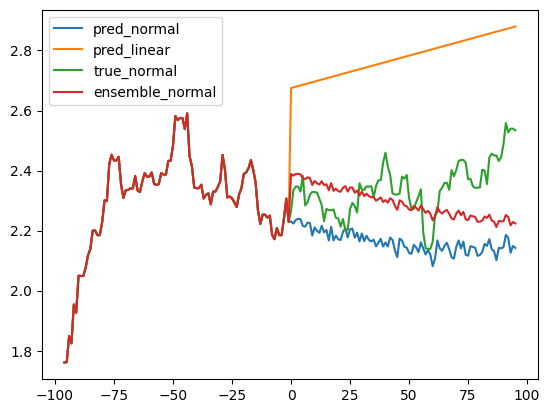

In [103]:
# 그래프 그리기
idx = 400
val = 7
xval = range(96)
xval2 = range(-96, 96)
plt.plot(xval2, np.concatenate([np_true[idx-96, :, val], np_pred[idx, :, val]]), label='pred_normal')
plt.plot(xval2, np.concatenate([np_true[idx-96, :, val],np_pred_lin[idx, :, val]]), label='pred_linear')
plt.plot(xval2, np.concatenate([np_true[idx-96, :, val],np_true[idx, :, val]]), label='true_normal')
plt.plot(xval2, np.concatenate([np_true[idx-96, :, val],final_res_scale[idx, :, val]]), label='ensemble_normal')
plt.savefig('aux_exemplar_graph_result.png')
plt.legend()
plt.show()

In [65]:
a,b,c

(0.369961678981781, 0.16650888323783875, 0.1557094305753708)

In [66]:
# 메트릭 비교하기 (원본 iTransformer)
MSE(np_pred[:,:,-1], np_true[:,:,-1]), MAE(np_pred[:,:,-1], np_true[:,:,-1]), SMAE(np_pred[:,:,-1], np_true[:,:,-1]), 

(0.09672106, 0.23337734, -0.04462888)

In [67]:
# 메트릭 비교하기 (스케일 수정)
MSE(final_res_scale[:,:,-1], np_true[:,:,-1]), MAE(final_res_scale[:,:,-1], np_true[:,:,-1]), SMAE(final_res_scale[:,:,-1], np_true[:,:,-1]), 

(0.13292721, 0.27322164, -0.13784547)

In [68]:
# 초기값 재수정

In [69]:
combine_model_test_2 = CombinedModel(res_iTransformer, res_lin_reg, res_lin_reg_24)
combine_model_test_2.a = nn.Parameter(torch.ones(1, device=exp_model.device)*1e-5, requires_grad=True)

In [70]:
combine_model_test_2.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combine_model_test_2.parameters(), lr=0.001)

In [71]:
cnt = 0
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
    # if i in selected_indices:
        cnt += 1
        batch_x = batch_x.float().to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
        targets = batch_y[:, -args.pred_len:, :].to(exp_model.device)
        optimizer.zero_grad()
        outputs = combine_model_test_2(batch_x)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (cnt+1) % 100 == 0:
            print(f"batch {cnt+1} done, loss {loss}") 

batch 100 done, loss 0.33668360114097595
batch 200 done, loss 0.27128201723098755
batch 300 done, loss 0.29298245906829834
batch 400 done, loss 0.11319850385189056
batch 500 done, loss 0.3063564598560333


In [72]:
combine_model_test_2.a, combine_model_test_2.b, combine_model_test_2.c # train 되지 않은 상태

(Parameter containing:
 tensor([0.2802], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2705], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2450], device='cuda:0', requires_grad=True))

In [73]:
# 2nd try
cnt = 0
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
    # if i in selected_indices:
        cnt += 1
        batch_x = batch_x.float().to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
        targets = batch_y[:, -args.pred_len:, :].to(exp_model.device)
        optimizer.zero_grad()
        outputs = combine_model_test_2(batch_x)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (cnt+1) % 100 == 0:
            print(f"batch {cnt+1} done, loss {loss}") 

batch 100 done, loss 0.22728446125984192
batch 200 done, loss 0.08372265100479126
batch 300 done, loss 0.08615975081920624
batch 400 done, loss 0.10330363363027573
batch 500 done, loss 0.26541751623153687


In [74]:
combine_model_test_2.a, combine_model_test_2.b, combine_model_test_2.c # train 되지 않은 상태

(Parameter containing:
 tensor([0.3660], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.3044], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2339], device='cuda:0', requires_grad=True))

In [75]:
#3rd try
cnt = 0
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
    # if i in selected_indices:
        cnt += 1
        batch_x = batch_x.float().to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
        targets = batch_y[:, -args.pred_len:, :].to(exp_model.device)
        optimizer.zero_grad()
        outputs = combine_model_test_2(batch_x)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (cnt+1) % 100 == 0:
            print(f"batch {cnt+1} done, loss {loss}") 

batch 100 done, loss 0.22634157538414001
batch 200 done, loss 0.0850565955042839
batch 300 done, loss 0.0826105922460556
batch 400 done, loss 0.08107264339923859
batch 500 done, loss 0.24882075190544128


In [76]:
combine_model_test_2.a, combine_model_test_2.b, combine_model_test_2.c # train 되지 않은 상태

(Parameter containing:
 tensor([0.4320], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2977], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1941], device='cuda:0', requires_grad=True))

In [77]:
#4th try
cnt = 0
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
    # if i in selected_indices:
        cnt += 1
        batch_x = batch_x.float().to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
        targets = batch_y[:, -args.pred_len:, :].to(exp_model.device)
        optimizer.zero_grad()
        outputs = combine_model_test_2(batch_x)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (cnt+1) % 100 == 0:
            print(f"batch {cnt+1} done, loss {loss}") 

batch 100 done, loss 0.2193181961774826
batch 200 done, loss 0.08756440877914429
batch 300 done, loss 0.08383649587631226
batch 400 done, loss 0.06514503061771393
batch 500 done, loss 0.23681865632534027


In [78]:
combine_model_test_2.a, combine_model_test_2.b, combine_model_test_2.c # train 되지 않은 상태

(Parameter containing:
 tensor([0.4970], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2802], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1623], device='cuda:0', requires_grad=True))

In [79]:
#5th try
cnt = 0
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
    # if i in selected_indices:
        cnt += 1
        batch_x = batch_x.float().to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
        targets = batch_y[:, -args.pred_len:, :].to(exp_model.device)
        optimizer.zero_grad()
        outputs = combine_model_test_2(batch_x)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (cnt+1) % 100 == 0:
            print(f"batch {cnt+1} done, loss {loss}") 

batch 100 done, loss 0.21431958675384521
batch 200 done, loss 0.09090274572372437
batch 300 done, loss 0.08514269441366196
batch 400 done, loss 0.055267881602048874
batch 500 done, loss 0.2286139577627182


In [80]:
combine_model_test_2.a, combine_model_test_2.b, combine_model_test_2.c # train 되지 않은 상태

(Parameter containing:
 tensor([0.5568], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2561], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1397], device='cuda:0', requires_grad=True))

In [81]:
MSE(preds_te_tr, trues_te_tr), MAE(preds_te_tr, trues_te_tr), SMAE(preds_te_tr, trues_te_tr)

(0.32300097, 0.39706883, 0.3094158)

In [82]:
# 실제 테스트 셋 불러와서 처리
a2, b2, c2 = combine_model_test_2.a[0].item(), combine_model_test_2.b[0].item(), combine_model_test_2.c[0].item()

In [83]:
MSE(a2*preds_te_tr + b2*preds_te_lin + c2*preds_te_lin_24, trues_te_tr), MAE(a2*preds_te_tr + b2*preds_te_lin + c2*preds_te_lin_24, trues_te_tr),  SMAE(a2*preds_te_tr + b2*preds_te_lin + c2*preds_te_lin_24, trues_te_tr)

(0.17597659, 0.28710604, 0.17175919)

In [84]:
a3, b3, c3 = a2/(a2+b2+c2), b2/(a2+b2+c2), c2/(a2+b2+c2)

In [85]:
MSE(a3*preds_te_tr + b3*preds_te_lin + c3*preds_te_lin_24, trues_te_tr), MAE(a3*preds_te_tr + b3*preds_te_lin + c3*preds_te_lin_24, trues_te_tr),  SMAE(a3*preds_te_tr + b3*preds_te_lin + c3*preds_te_lin_24, trues_te_tr)

(0.1840128, 0.29199687, 0.18119442)

In [86]:
print(a2,b2,c2)
print(a3,b3,c3)

0.5567907094955444 0.2560894787311554 0.13965775072574615
0.5845338927999816 0.26884963659588185 0.1466164706041366


In [87]:
# 마지막으로 비교
final_res1 = a2*np_pred + b2* np_pred_lin + c2*np_pred_lin_24
final_res_scale1 =a3*np_pred + b3*np_pred_lin + c3*np_pred_lin_24

In [88]:
# 메트릭 비교하기 (원본 iTransformer)
MSE(np_pred, np_true), MAE(np_pred, np_true), SMAE(np_pred, np_true), REC_CORR(np_pred, np_true), STD_RATIO(np_pred, np_true), SLOPE_RATIO(np_pred, np_true)

(0.087919034,
 0.20848815,
 -0.067817636,
 -0.0024424494137001824,
 3.3577824,
 0.3202987727519611)

In [89]:
# 메트릭 비교하기 (조합)
MSE(final_res1, np_true), MAE(final_res1, np_true), SMAE(final_res1, np_true), REC_CORR(final_res1, np_true), STD_RATIO(final_res1, np_true), SLOPE_RATIO(final_res1, np_true)

(0.12063064,
 0.25416753,
 -0.13706586,
 0.03797293135459037,
 2.9307492,
 0.34368274615384187)

In [90]:
# 메트릭 비교하기 (조합)
MSE(final_res_scale1, np_true), MAE(final_res_scale1, np_true), SMAE(final_res_scale1, np_true), REC_CORR(final_res_scale1, np_true), STD_RATIO(final_res_scale1, np_true), SLOPE_RATIO(final_res_scale1, np_true)

(0.16183467,
 0.29831642,
 -0.2024223,
 0.03797292264654617,
 2.8131137,
 0.3468150330730737)

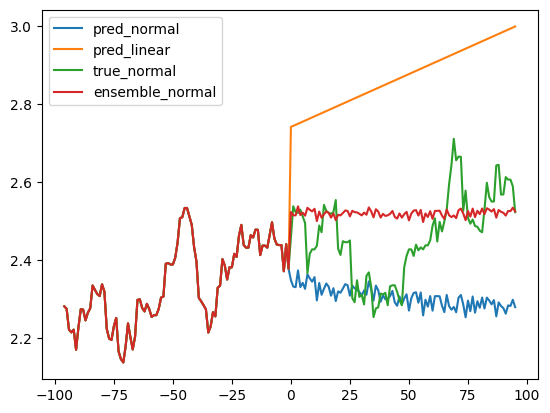

In [91]:
# 그래프 그리기
idx =97
val = 7
xval = range(96)
xval2 = range(-96, 96)
plt.plot(xval2, np.concatenate([np_true[idx-96, :, val], np_pred[idx, :, val]]), label='pred_normal')
plt.plot(xval2, np.concatenate([np_true[idx-96, :, val],np_pred_lin[idx, :, val]]), label='pred_linear')
plt.plot(xval2, np.concatenate([np_true[idx-96, :, val],np_true[idx, :, val]]), label='true_normal')
plt.plot(xval2, np.concatenate([np_true[idx-96, :, val],final_res_scale[idx, :, val]]), label='ensemble_normal')
plt.legend()
plt.show()

In [92]:
a,b,c

(0.369961678981781, 0.16650888323783875, 0.1557094305753708)

In [93]:
# 메트릭 비교하기 (원본 iTransformer)
MSE(np_pred[:,:,-1], np_true[:,:,-1]), MAE(np_pred[:,:,-1], np_true[:,:,-1]), SMAE(np_pred[:,:,-1], np_true[:,:,-1]), 

(0.09672106, 0.23337734, -0.04462888)

In [94]:
# 메트릭 비교하기 (스케일 수정)
MSE(final_res_scale[:,:,-1], np_true[:,:,-1]), MAE(final_res_scale[:,:,-1], np_true[:,:,-1]), SMAE(final_res_scale[:,:,-1], np_true[:,:,-1]), 

(0.13292721, 0.27322164, -0.13784547)

In [95]:
# ensemble model test